In [2]:
from tensorial_algebra import *
from utils import *
from frictions import * 

We consider new payoffs that cannot be exactly represented as signature payoffs as it is in the case for European, Asian or barrier call option, in contrast with payoffs considered in `signature-payoffs.ipynb`. By relying on the universal linearization proporty of signatures, we can approximate those payoffs by signature payoffs, i.e. by linear combination of time-augmented signature elements. More precisely, for a continuous functional $F$, a continuous semimartingale $(Y_t)_{t\in [0,T]}$ valued in $\mathbb R^d$, and a given truncation order $M > 0$, there exists $\ell \in T^M(\mathbb R^{d+1})$ such that $$F\left((t,Y_t)_{t\in [0,T]}\right) \approx \left\langle \ell, \widehat{\mathbb{Y}}_t\right\rangle.$$

This means that the semi-explicit signature-based hedging strategy can also be used to hedge general (non-signature) path-dependent payoffs. However, to apply the signature-based hedging strategy, we first gave to regress those path-dependent payoffs against truncatured signature payoffs to determine $\ell$, and then solve the infinite-dimensional Riccati equation associated with the signature approximate payoff $\left\langle \ell, \widehat{\mathbb{Y}}_t\right\rangle$. 

As described in [Abi Jaber, Hainaud and Motte (2025)](https://www.arxiv.org/pdf/2511.23295), a linear regression approach is appropriate in this setting. However, it should be noted that the resulting coefficients may take large values, which is why a Ridge regularization is preferred here.

## I. Frictionless market 

In [104]:
S0 = K = 10 
mu = 0
sigma = 2 
n = 252 
T = 0.2 
N = 200
x0 = N * 0.5  # atm call 
t_grid = np.linspace(0, T, n+1) 

### I.1. Regression

In [90]:
N_mc = 100000
W_mc = generate_brownian_paths(N_mc, n, T)
Y = simulate_Bachelier(S0, T, mu, sigma, W_mc)

H = N * np.maximum(Y[:, -1] - K, 0.0)
M = 5
d = 2
S = signatures_time_augmented(Y, T, M)

In [96]:
alphas = np.logspace(-4, 8, 60)   
l0, l, alpha_star, model = fit_Ridge_CV(S, H, alphas=alphas)
l_dict = vector_to_dict(l, d, M)
l_dict[()] = l0 

In [98]:
l0_OLS, l_OLS, model_OLS = fit_OLS(S, H)

In [100]:
l_dict = vector_to_dict(l, d, M)
l_dict[()] = l0

In [102]:
W2 = generate_brownian_paths(20000, n, T)
Y2 = simulate_Bachelier(S0, T, mu, sigma, W2)
H2 = N * np.maximum(Y2[:, -1] - K, 0.0)
S2 = signatures_time_augmented(Y2, T, M)

H2_hat = model.predict(S2)
rmse2 = np.sqrt(np.mean((H2 - H2_hat)**2))
r2_2  = 1 - np.sum((H2-H2_hat)**2)/np.sum((H2-H2.mean())**2)

print("alpha* = ", alpha_star, "rmse2 = ", rmse2, "r2 = ", r2_2)

alpha* =  515.0678076168133 rmse2 =  12.123402903179654 r2 =  0.9863219319888764


### I.2. Comparison with Delta hedging strategy 

In [106]:
N_mc = 1000
W = generate_brownian_paths(N_mc, n, T)

In [108]:
S = simulate_Bachelier(S0, T, mu, sigma, W)
X_bachelier = N * delta_Bachelier(T, mu, sigma, S, K, flag="call")
X_sig = compute_X_frictionless(T, S0, x0, mu, sigma, l_dict, W, M) 

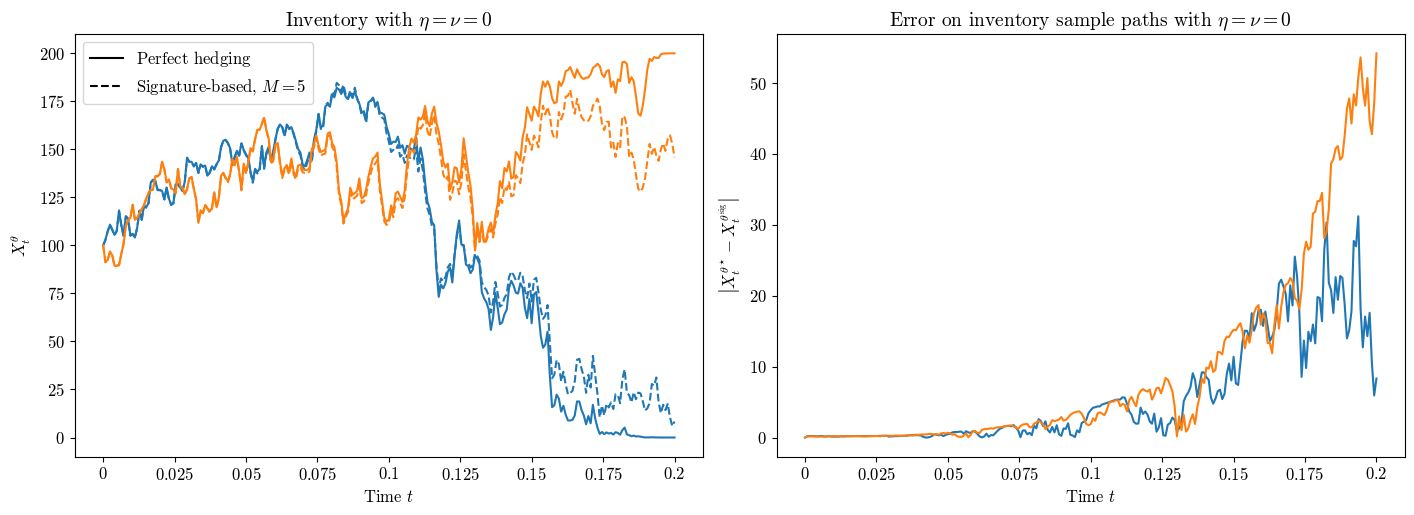

In [169]:
plot_inventory_frictionless(X_bachelier, X_sig, t_grid, n_tests = [21, 24])

The truncation order $M=5$ doesn't appear to be sufficient in this configuration to provide accurate estimates. We discuss this point in more detail in the next section.

## II. Frictional market 

### II.1. Comparison with the Almgren and Li strategy 

The value function $J(t,p,x)$ satisfies a nonlinear HJB equation of the following form : 
\begin{align*}
&J_t = -\frac{\lambda}{2}\sigma^2\left(x - \Delta(t,p)\right)^2 - \frac{\sigma^2}{2}J_{pp} + \frac{1}{4\eta}\left(\nu(x-\Delta(t,p))-J_x - \nu J_{pp}\right)^2,\\
&J(T, p, x) = 0.
\end{align*}

When $\Gamma(t,p)$ is constant, i.e. $\Gamma(t,p) = \Gamma \in \mathbb R$, and $\mu = 0$, a closed solution is available. This explicit solution follows from the fact that, when $\Gamma$ is constant, the problem becomes linear-quadratic : the delta is therefore linear in $p$, and the payoff is quadratic. 

We emphasize that $\Delta(t,p) = N\times\Phi\left(\frac{p-K}{\sigma\sqrt{T-t}}\right)$, where $\Phi$ is the cumulative distribution function of $\mathcal N (0,1)$, and $N$ the nominal. 

Using this information, for an European call payoff, we compare the signature-based strategy associated to the regressed signature payoff with the optimal strategy obtained by numerically solving the above HJB equation. This allows us to see whether, in this context of market impact, the signature-based strategies are able to well aproximate the optimal strategy when payoffs do not admit an exact signature representation. 

#### II.1.1. Resolution of the HJB equation

In [11]:
N = 200

In [45]:
coeff = 4

In [47]:
T, mu, sigma, eta, nu, lambd, K, Nt, Np, Nx, x_min, x_max = 0.2, 0.0, 2, 0.001, 0.001, 0.01, 10, 252 * coeff , 50 * coeff , 50 * coeff, -2 * N, 2 * N 

J, t_grid, p_grid, x_grid = solve_hjb_equation(T, mu, sigma, eta, nu, lambd, K, Nt, Np, Nx, N, x_min, x_max, p_min=None, p_max=None, verbose=True) 

Resolution completed in 0.26s
Speed: 156,767,051 points/second


In [49]:
Jp, Jx = compute_Jp_Jx_grids(J, p_grid, x_grid) 

#### II.1.2. Regression

In [25]:
S0 = K = 10 
mu = 0
sigma = 2 
n = 252 
T = 0.2 
N = 200
x0 = N * 0.5 # atm call 
t_grid = np.linspace(0, T, n+1) 

In [19]:
N_mc = 100000
W_mc = generate_brownian_paths(N_mc, n, T)
Y = simulate_Bachelier(S0, T, mu, sigma, W_mc)

H = N * np.maximum(Y[:, -1] - K, 0.0)
M = 5
d = 2
S = signatures_time_augmented(Y, T, M)

In [20]:
alphas = np.logspace(-4, 8, 60)   
l0, l, alpha_star, model = fit_Ridge_CV(S, H, alphas=alphas)
l_dict = vector_to_dict(l, d, M)
l_dict[()] = l0 

In [21]:
data = np.load("projectors_d3_tildeM10.npz")

projectors = (
    data["proj_1_src"],
    data["proj_1_tgt"],
    data["proj_2_src"],
    data["proj_2_tgt"],
    data["proj_3_src"],
    data["proj_3_tgt"],
    data["proj_22_src"],
    data["proj_22_tgt"],
)

data = np.load("tuples_d3_tildeM10.npz")

tuples = (
    data["sh_i"],
    data["sh_j"],
    data["sh_k"],
    data["sh_mult"],
)

In [27]:
d = 3
psi = compute_psi(T, n, x0, mu, sigma, eta, nu, lambd, l_dict, d, M, projectors, tuples, verbose=True)

100%|█████████████████████████████████████████| 252/252 [04:35<00:00,  1.09s/it]


In [29]:
N_mc = 10
W = generate_brownian_paths(N_mc, n, T)

In [31]:
X_call, S_call, P_call, theta_call = compute_theta(T, S0, x0, mu, sigma, eta, nu, lambd, psi, l_dict, W, M, verbose=True)

100%|████████████████████████████████████████| 252/252 [00:01<00:00, 183.29it/s]


In [51]:
X, S, P, theta = compute_theta_hjb_numba(T, S0, x0, mu, sigma, eta, nu, W, K, N, Jp, Jx, t_grid, p_grid, x_grid)

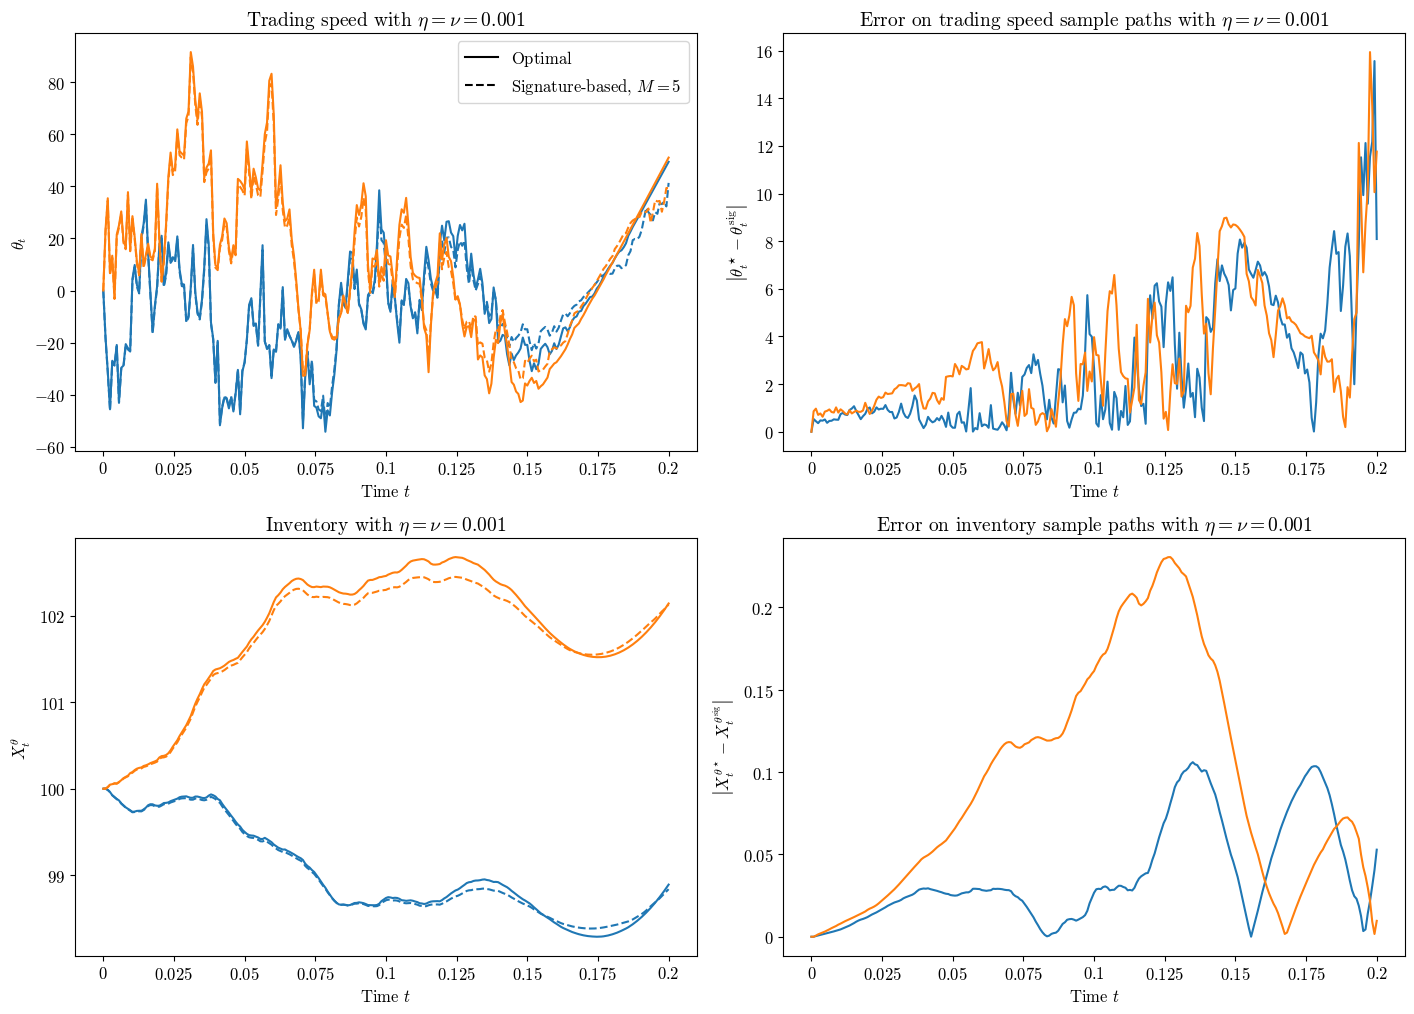

In [67]:
plot_inventory_hjb(X, X_call, theta, theta_call, n_tests=[2,3], T=T, n=n)

By contrast with the frictionless setting, the signature approximation performs significantly better in the presence of market impact. In this case, the sample paths of trading speeds and inventories generated by the signature-based approach are much closer to the optimal strategy. This improvement can be attributed to two effects:
- Market impact naturally smooths the optimal trading speeds,
- The signature-approximated payoff leads to a smoother target (perfect hedging) strategy compared to the European call payoff, which becomes stiff near maturity.
  
In this setting, a fifth-order truncation of the signature is already sufficiently accurate for both pricing and hedging.

### II.2. More payoffs 

We now emphasize the relevance of signature-based strategies to hedge non-signature path-dependent payoffs when $\nu > 0$. To this end, we consider different types of options: 
- European call,
- Asian call,
- One-touch,
- Look-back call with floating strike.

As in `signature-payoffs.ipynb`, it is relevant to compare the $\text{P\&L}$ generated by two types of traders: the first one is aware of the permanent market impact and follows a signature-based strategy for $\nu > 0$, while the second one ignores the permanent market impact and follows the trading strategy [Bank, Soner and Voß](https://arxiv.org/pdf/1510.03223), which consists of tracking the Bachelier Delta of the non-signature payoffs. We leave this comparison for future work, in order to focus exclusively on the signature-based approach in the present study.


Recall that the $\text{P\&L}$ at time $T$ is defined as $$R_T^\theta = \widetilde\pi- X_0S_0 + X_T^\theta P_T^\theta - \int_0^T \widetilde P_t^\theta \theta_t \, dt - H_T^\theta,$$ 
where the unknown indifference price $\widetilde \pi$ is such that it satisfied the following criterion 
$$\mathbb E\left[R_T^\theta - \frac\lambda 2 \left[R^\theta, R^\theta\right]_T\right] = 0.$$

In [57]:
S0 = K = 10 
mu = 0 
sigma = 2 
eta = nu = 0.001 
lambd = 0.01 
T = 0.2
n = 252
N = 200

In [59]:
N_mc = 100000
W_mc = generate_brownian_paths(N_mc, n, T)
Y = simulate_Bachelier(S0, T, mu, sigma, W_mc)

d = 3
M = 5
tilde_M = 2*M 
S = signatures_time_augmented(Y, T, M)

In [60]:
N_mc = 1000
W = generate_brownian_paths(N_mc, n, T)

In [61]:
data = np.load("projectors_d3_tildeM10.npz")

projectors = (
    data["proj_1_src"],
    data["proj_1_tgt"],
    data["proj_2_src"],
    data["proj_2_tgt"],
    data["proj_3_src"],
    data["proj_3_tgt"],
    data["proj_22_src"],
    data["proj_22_tgt"],
)

data = np.load("tuples_d3_tildeM10.npz")

tuples = (
    data["sh_i"],
    data["sh_j"],
    data["sh_k"],
    data["sh_mult"],
)

#### II.2.1. European call: $H_T^\theta = N\times(P_T^\theta-K)^+$

In the Bachelier model, i.e. $S_t = S_0 + \sigma W_t$, it is clear that the conditional distribution of the terminal price is Gaussian:
$$\mathscr{L}\big(S_T\big|\mathscr{F}_t\big) = \mathcal N\left(S_t, \sigma^2(T-t)\right),$$
and therefore 
$$C_t^\text{Europ} = \left((S_t-K)\Phi(d_t) + \sigma\sqrt{T-t}\phi(d_t)\right), \quad d_t := \frac{S_t - K}{\sigma\sqrt{T-t}},$$
where $\Phi$ and $\phi$ denote respectively the standard normal cdf and pdf. Then, 
$$\Delta_t^\text{Europ} = \Phi(d_t).$$

In [65]:
x0 = N * 0.5 # atm call 

In [67]:
payoff = N * np.maximum(Y[:, -1] - K, 0.0)

In [69]:
alphas = np.logspace(-4, 8, 60)   
l0, l, alpha_star, model = fit_Ridge_CV(S, payoff, alphas = alphas)

In [70]:
d = 2
l_dict = vector_to_dict(l, d, M)
l_dict[()] = l0 

In [71]:
d = 3
psi = compute_psi(T, n, x0, mu, sigma, eta, nu, lambd, l_dict, d, M, projectors, tuples, verbose=True)

100%|█████████████████████████████████████████| 252/252 [04:32<00:00,  1.08s/it]


In [72]:
X_call, S_call, P_call, theta_call = compute_theta(T, S0, x0, mu, sigma, eta, nu, lambd, psi, l_dict, W, M, verbose=True)

100%|█████████████████████████████████████████| 252/252 [02:49<00:00,  1.49it/s]


In [77]:
prices_call = np.zeros((N_mc, n+1))
for i in range(n) : 
    prices_call[:, i] = N * price_europ_Bachelier(P_call[:, i], T, mu, sigma, K, t=i*T/n)
prices_call[:, -1] = N * np.maximum(P_call[:, -1] -K, 0.0)

In [90]:
mean, _, lower, upper = estimate_pi(T, S0, x0, eta, lambd, X_call, P_call, theta_call, prices_call)

In [103]:
V0 = 84.92 

In [105]:
R = compute_R_T(T, S0, x0, sigma, eta, V0, X_call, P_call, theta_call, payoff_call) 

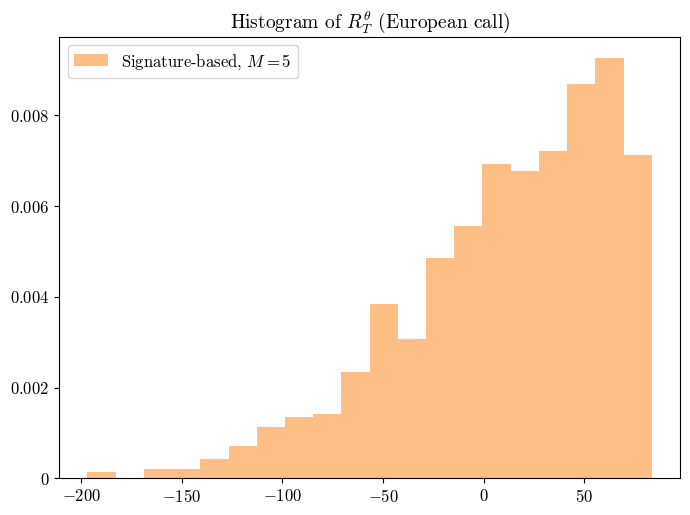

In [141]:
plot_histogram_R_sig(R, title=r"$\text{Histogram of }R_T^\theta \text{ (European call)}$") 

#### II.2.2. Asian call: $H_T^\theta = N\times\left(\frac{1}{T}\int_0^T P_t^\theta\, dt-K\right)^+$

Conditionally on $\mathscr F_t$, the terminal average $A_T$ is Gaussian:$$\mathscr L \big(A_T \big|\mathscr F_t\big) = \mathcal N\left(m_t, v_t\right),\qquad A_T := \frac 1T \left(\int_0^t S_u \, du + \int_t^T S_u\, du\right), \qquad m_t = \frac 1T \int_0^t S_u\, du + \frac{T-t}{T}S_t, \qquad v_t = \frac{\sigma^2}{3T^2}(T-t)^3.$$
Therefore 
$$C_t^\text{Asian} = (m_t - K)\Phi(d_t) + \sqrt{v_t}\phi(d_t), \qquad d_t := \dfrac{m_t - K}{\sqrt{v_t}}.$$
Since $m_t$ depends linearly on $S_t$ with coefficient $(T-t)/T$, the Delta is
$$\Delta_t^\text{Asian}=\frac{T-t}{T}\,\Phi\left(d_t\right).$$

In [148]:
x0 = N * 0.5 # atm call 

In [144]:
integrales = last_integrale(Y, T, log=False)
payoff = N * np.maximum(integrales - K, 0.0)

In [146]:
alphas = np.logspace(-4, 8, 60)
l0, l, alpha_star, model = fit_Ridge_CV(S, payoff, alphas = alphas)

In [219]:
d = 2
l_dict = vector_to_dict(l, d, M)
l_dict[()] = l0 

In [150]:
d = 3
psi = compute_psi(T, n, x0, mu, sigma, eta, nu, lambd, l_dict, d, M, projectors, tuples, verbose=True)

100%|█████████████████████████████████████████| 252/252 [04:36<00:00,  1.10s/it]


In [151]:
X_asian, S_asian, P_asian, theta_asian = compute_theta(T, S0, x0, mu, sigma, eta, nu, lambd, psi, l_dict, W, M, verbose=True)

100%|█████████████████████████████████████████| 252/252 [02:43<00:00,  1.54it/s]


In [199]:
partial_integrals.shape

(1000, 253)

In [211]:
prices_call_asian = np.zeros((N_mc, n+1))
partial_integrals = integrals(S_asian, T, log=False)
for i in range(n) : 
    m_t = partial_integrals[:, i] + (T - i*T/n) / T * S_asian[:, i]
    v_t = sigma**2 / (3*T**2) * (T - i*T/n)**3
    d_t = (m_t - K) / np.sqrt(v_t) 
    prices_call_asian[:, i] = N * ((m_t - K) * norm.cdf(d_t) + np.sqrt(v_t) * norm.pdf(d_t))
prices_call_asian[:, -1] = N * np.maximum(partial_integrals[:, -1] -K, 0.0)

In [213]:
mean, _, lower, upper = estimate_pi(T, S0, x0, eta, lambd, X_asian, P_asian, theta_asian, prices_call_asian) 

In [225]:
mean = np.round(mean, 2)
mean 

56.97

In [228]:
integrales = last_integrale(P_asian, T, log=False)
payoff_asian = N * np.maximum(integrales - K, 0.0)

In [230]:
R = compute_R_T(T, S0, x0, sigma, eta, mean, X_asian, P_asian, theta_asian, payoff_asian) 

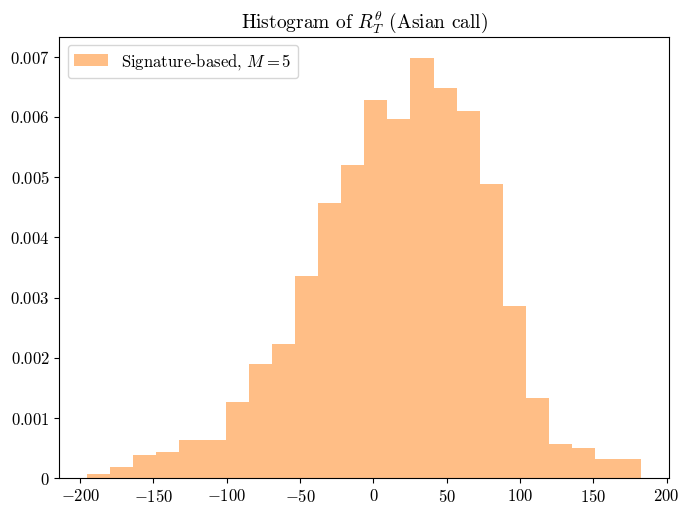

In [232]:
plot_histogram_R_sig(R, title=r"$\text{Histogram of }R_T^\theta \text{ (Asian call)}$") 

#### II.2.3. One-touch max: $H_T^\theta = N\times \mathbf{1}_{\left\{\max_{t<T} P_t^\theta \geq H\right\}}$

Define the running maximum of the underlying price process by $M_t := \max_{0 \le u \le t} S_u.$ If $M_t \ge H$, the option has already knocked in and its value at time $t$ (denoted by $V_t$) is deterministic: $V_t = N$. Assume now that $M_t < H$. Conditioned on $\mathscr F_t$, the future evolution of the process satisfies $S_{t+s} - S_t = \sigma \widetilde W_s$, $s \in [0, T-t]$, where $(\widetilde W_s)_{s \ge 0}$ is a standard Brownian motion independent of $\mathscr F_t$. Using the reflection principle, we obtain

$$\mathbb P\left(\sup_{0 \le s \le T-t} \sigma \widetilde W_s \ge H - S_t\right) = 2\Big(1 - \Phi\Big(\frac{H-S_t}{\sigma\sqrt{T-t}}\Big)\Big) = 2\,\Phi\Big(\frac{S_t-H}{\sigma\sqrt{T-t}}\Big).$$

Therefore, when $M_t < H$, $$V_t = N \cdot 2\,\Phi\Big(\frac{S_t-H}{\sigma\sqrt{T-t}}\Big), \qquad \Delta_t
= \frac{2N}{\sigma\sqrt{T-t}}\,
\phi\Big(\frac{S_t-H}{\sigma\sqrt{T-t}}\Big).$$

In [255]:
H = 1.05 * S0 
x0 = 2 * N / (sigma * np.sqrt(T)) * norm.pdf((S0 - H) / (sigma * np.sqrt(T)))

In [274]:
payoff = N * (np.max(Y, axis=1) >= H).astype(float)

In [281]:
alphas = np.logspace(-4, 8, 60)
l0, l, alpha_star, model = fit_Ridge_CV(S, payoff, alphas = alphas)

In [283]:
d = 2
l_dict = vector_to_dict(l, d, M)
l_dict[()] = l0 

In [285]:
d = 3
psi = compute_psi(T, n, x0, mu, sigma, eta, nu, lambd, l_dict, d, M, projectors, tuples, verbose=True)

100%|█████████████████████████████████████████| 252/252 [04:38<00:00,  1.10s/it]


In [287]:
X_onetouch, S_onetouch, P_onetouch, theta_onetouch = compute_theta(T, S0, x0, mu, sigma, eta, nu, lambd, psi, l_dict, W, M, verbose=True)

100%|█████████████████████████████████████████| 252/252 [02:40<00:00,  1.57it/s]


In [289]:
prices_onetouch = np.zeros_like(P_onetouch)
running_max = np.maximum.accumulate(P_onetouch, axis=1)

t_grid = np.linspace(0, T, n+1) 

for i in range(n):
    tau = T - t_grid[i]
    tau = max(tau, 1e-12)
    hit = running_max[:, i] >= H
    z = (H - P_onetouch[:, i]) / (sigma * np.sqrt(tau))
    prob_hit = 2.0 * (1.0 - norm.cdf(z))
    prices_onetouch[:, i] = N * np.where(hit, 1.0, prob_hit)
    prices_onetouch[:, -1] = N * (running_max[:, -1] >= H)

In [291]:
mean, _, lower, upper = estimate_pi(T, S0, x0, eta, lambd, X_onetouch, P_onetouch, theta_onetouch, prices_onetouch) 

In [302]:
mean = np.round(mean, 2)
mean

156.9

In [304]:
payoff_onetouch = N * (np.max(P_onetouch, axis=1) >= H).astype(float)

In [306]:
R = compute_R_T(T, S0, x0, sigma, eta, mean, X_onetouch, P_onetouch, theta_onetouch, payoff_onetouch)

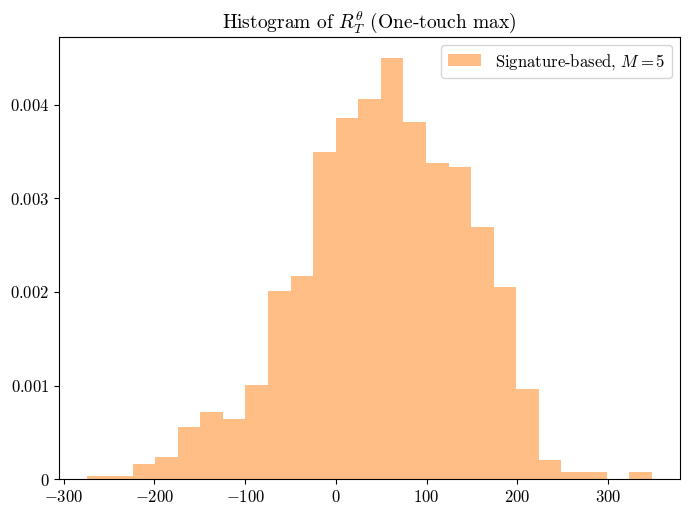

In [308]:
plot_histogram_R_sig(R, title=r"$\text{Histogram of }R_T^\theta \text{ (One-touch max)}$") 

#### II.2.4. Look-back call with floating strike: $H_T^\theta = N\times \left( P_T^\theta - \min_{t< T} P_t^\theta\right)$

Let $S_t = S_0 + \sigma W_t$ and define the running minimum $m_t := \min_{0\le u\le t} S_u.$ By the weak Markov property of the Brownian motion, $S_{t+s} = S_t + \sigma \widetilde W_s,$ where $\widetilde W$ is independent with respect to $\mathscr F_t$. Then,  
$$m_T = \min\Big(m_t,\ \min_{0\le s\le T-t} S_{t+s}\Big)
     = \min\Big(m_t,\ S_t + \sigma \min_{0\le s\le T-t}\widetilde W_s\Big).$$
Let $a := S_t - m_t \ge 0$ (the drawdown above the running minimum). Using the identity $\widetilde W_{T-t} - \min_{0\le s\le T-t}\widetilde W_s \overset{d}{=}  |\widetilde W_{T-t}|$ and the fact that the post-$t$ increments are independent of $\mathscr F_t$, one obtains the (conditional) distributional representation
$$\mathscr L\big(S_T - m_T \big| \mathscr F_t\big)= \mathscr L\big(a + \sigma|\widetilde W_{T-t}|\big) = \mathscr L\big(S_t - m_t + \sigma|W_{T-t}|\big).$$

Taking conditional expectations, 
$$V_t = N\left(S_t - m_t + \sigma\,\mathbb E\left[|W_{T-t}|\right]\right) = N\left(S_t - m_t + \sigma\sqrt{T-t}\sqrt{\frac{2}{\pi}}\right).$$
Away from the non differentiable boundary $\{S_t = m_t\}$, $\Delta_t = N \mathbf 1_{\{S_t>m_t\}}$. In particular, $\Delta_0 =0$.

In [332]:
x0 = N * 0

In [312]:
payoff = N * (Y[:, -1] - np.min(Y, axis=1))

In [317]:
alphas = np.logspace(-4, 8, 60)
l0, l, alpha_star, model = fit_Ridge_CV(S, payoff, alphas = alphas)

In [334]:
d = 2
l_dict = vector_to_dict(l, d, M)
l_dict[()] = l0 

In [336]:
d = 3
psi = compute_psi(T, n, x0, mu, sigma, eta, nu, lambd, l_dict, d, M, projectors, tuples, verbose=True)

100%|█████████████████████████████████████████| 252/252 [04:37<00:00,  1.10s/it]


In [338]:
X_lookback, S_lookback, P_lookback, theta_lookback = compute_theta(T, S0, x0, mu, sigma, eta, nu, lambd, psi, l_dict, W, M, verbose=True)

100%|█████████████████████████████████████████| 252/252 [02:48<00:00,  1.49it/s]


In [349]:
prices_lookback = np.zeros_like(P_lookback)
running_min = np.minimum.accumulate(P_lookback, axis=1)

for i in range(n):
    tau = T - t_grid[i]
    tau = max(tau, 1e-12)
    Y_t = P_lookback[:, i] - running_min[:, i]
    prices_lookback[:, i] = N * (Y_t + sigma * np.sqrt(tau) * np.sqrt(2.0 / np.pi))
prices_lookback[:, -1] = N * (P_lookback[:, -1] - running_min[:, -1])

In [384]:
mean, _, lower, upper = estimate_pi(T, S0, x0, eta, lambd, X_lookback, P_lookback, theta_lookback, prices_lookback) 

In [388]:
mean = np.round(mean, 2)
mean

180.27

In [355]:
payoff_lookback = N * (P_lookback[:, -1] - np.min(P_lookback, axis=1))

In [357]:
R = compute_R_T(T, S0, x0, sigma, eta, mean, X_lookback, P_lookback, theta_lookback, payoff_lookback)

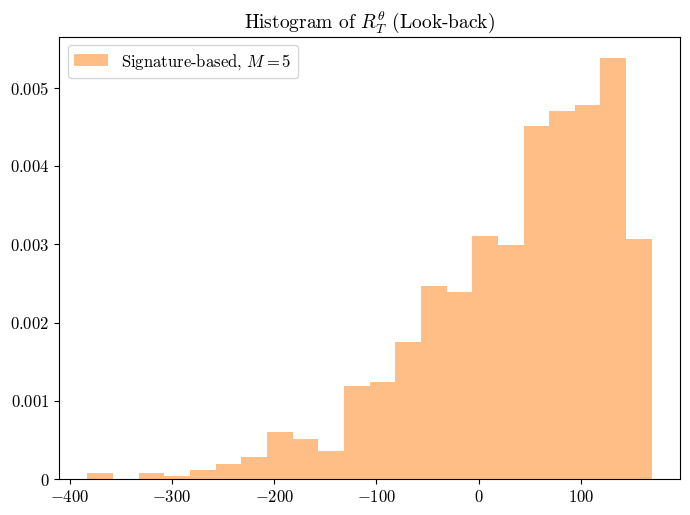

In [359]:
plot_histogram_R_sig(R, title=r"$\text{Histogram of }R_T^\theta \text{ (Look-back)}$") 

The above histograms closely reproduce those reported in Figure 6 of [Abi Jaber, Hainaud and Motte (2025)](https://www.arxiv.org/pdf/2511.23295). The latter shows that even though the signature-based strategy is an approximation of the optimal strategy, it seems very relevant for hedging non-signature payoffs in the presence of market frictions. 